Importing necessary libraries

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Defining necessary parameters

In [2]:
DATA_DIR = '../../Data/'         # Path to your dataset folder
IMG_SIZE = (224, 224)                # VGG16 input size
BATCH_SIZE = 32
EPOCHS = 10

Set up ImageDataGenerators for training and validation
Includes augmentation for training set

In [3]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,             # 80/20 train/val split
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

# Load training data
train_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Load validation data
val_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 8012 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


Load the VGG16 base model (pretrained on ImageNet)

In [4]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all convolutional layers so only our custom head is trained
for layer in base_model.layers:
    layer.trainable = False

Add custom classification head

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)        # Converts conv output to 1D
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Combine base + custom layers
model = Model(inputs=base_model.input, outputs=predictions)

Compile the model

In [6]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Train the model

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

c:\Users\azizc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.4997 - loss: 0.7160 - val_accuracy: 0.5027 - val_loss: 0.6951
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.5449 - loss: 0.6905 - val_accuracy: 0.4923 - val_loss: 0.6979
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.5407 - loss: 0.6885 - val_accuracy: 0.4883 - val_loss: 0.7034
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.5696 - loss: 0.6771 - val_accuracy: 0.4933 - val_loss: 0.7017
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.5742 - loss: 0.6773 - val_accuracy: 0.4858 - val_loss: 0.7039
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.5840 - loss: 0.6724 - val_accuracy: 0.5012 - val_loss: 0.7040
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.5863 - loss: 0.6695 - val_accuracy: 0.4878 - val_loss: 0.7100
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.5894 - loss: 0.6696 - val_accu

Evaluate the model

In [8]:
val_data.reset()
y_true = val_data.classes                        # True labels
y_pred = model.predict(val_data, verbose=1)      # Probabilities
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  # Convert to 0/1

# Classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['benign', 'malignant']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))

63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.72      0.59      1000
   malignant       0.51      0.28      0.36      1003

    accuracy                           0.50      2003
   macro avg       0.50      0.50      0.48      2003
weighted avg       0.50      0.50      0.48      2003

Confusion Matrix:
[[722 278]
 [719 284]]


Optional: Plot accuracy and loss curves

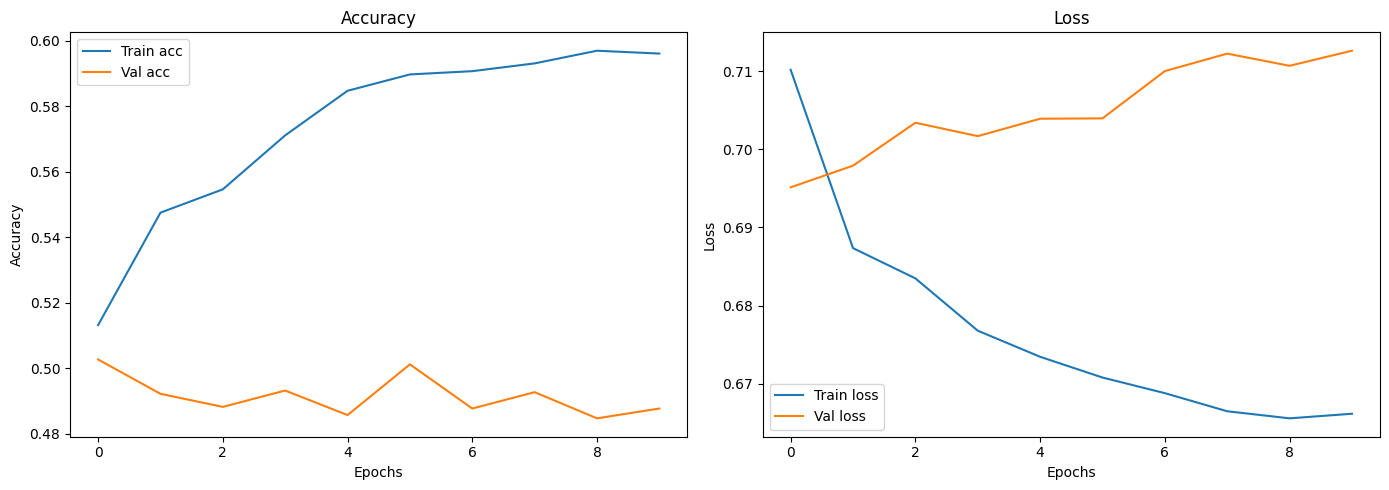

In [9]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()